### Notebook that looks for all matches of degrons motifs across all human proteome. Then it also classifies the degron-likeness of each degron using the RFC classifier. In detail this is the output of the notebook. 
- First for each consensous motif identifies matches across the proteome.
- Uses the classifier to predict the Random-likeness of each regex match.
- It also includes PPI information of the E3 ligase of regocognizing the motif and the target ( protein where the match is found)
- For each degron motif calculate the distribution of the values of the degron-likeness. It uses the minimal degron-likeness of the annotated degrons as threshold for high-confidence predictions. The distributions of degron motif matches is plotted in FigS2
- Represents the number and percentage of predicted instances for each of the degron motifs alongisde (Fig 2d)
- Supplementary S1e,f,g (Plot of the correlation between sequence lenght and number of degrons)






In [8]:
import pandas as pd
import os
import numpy as np
import re
from calculate_biochemical_properties import calculate_biochemical_properties
from sklearn.externals import joblib

In [9]:
%load_ext autoreload 
%autoreload 2

### paths

In [3]:
base="../" 

uniprot = os.path.join(base,"data/uniprot_isoforms.tsv")
sequences = os.path.join(base,"data/sequences_isoforms.tsv")
ppi = os.path.join(base,"data/ppi_all_targets.tsv.gz")


path_output_classes = os.path.join(base,"data/degron_classes.tsv")
path_output_instances = os.path.join(base,"data/degron_instances.tsv")

path_simulated_protein = os.path.join(base,"data","simulated_degrons_proteins.tsv.gz")
path_simulated_random = os.path.join(base,"simulated_degrons.tsv.gz") 

path_properties_annotated = os.path.join(base,"data","annotated_degrons_properties.tsv")

script_features = "./pipeline_calculate_features.sh"

type_simulations = "all"

path_output_plots = os.path.join(base,"plots","Figure1")

output_classifier_random  = os.path.join(base,"data","classifier_random.pickle")

path_output_dataframe = os.path.join(base,"data","predicte_degrons_properties.tsv.gz")

### Define simulated dataset

In [33]:
if type_simulations == "all":
    simulated = path_simulated_random
else:
    simulated = path_simulated_protein

### Definition of covariates

In [34]:
covariate_names=["ASA","DSS","F_CONS","COIL","ANCHOR","PHOSPHO_SITES","FLANKING_UB_SITES","HELIX","SHEET","RIG","DOMAIN"] # Labels
covariates =["ASA_SCORE","DSS_SCORE","FCONS_SCORE","COIL","ANCHOR_SCORE","nflanking_ptms","nflanking_ub_lysines","HELIX","STRAND","RIG_SCORE","Domain_pfam"]
response_var = "IS_DEGRON"

# 1. For each degron find any matches of the sequence

In [11]:
df_sequences = pd.read_csv(sequences,sep="\t")
df_dregon_types = pd.read_csv(path_output_classes,sep="\t")

### Number of sequences

In [80]:
df_sequences.shape

(32022, 5)

### Number of proteins

In [83]:
len(df_sequences["Hugo_Symbol"].unique())

19986

### 1.1. Create a dictionary with the motifs

In [36]:
d_motifs = {}
for index,row in df_dregon_types.iterrows():
    d_motifs[row["ELMIdentifier"]]=re.compile(row["Regex"])


#### 1.1.1 Match sequences with these degrons

In [37]:
l_results=[]
for index,row in df_sequences.iterrows():
    seq = row["Sequence"]
    for motif in d_motifs.keys():
        for m in re.finditer(d_motifs[motif],seq):
            l_results.append((row["Entry"],row["Entry_Isoform"],row["Hugo_Symbol"],row["CCDS"],m.group(),motif,m.start()+1,m.end()))
df_matches_seq = pd.DataFrame(l_results,columns=["Entry","Entry_Isoform","Hugo_Symbol","CCDS","Hit","DEGRON","START","END"])           

### 2. Annotate those degrons already known

In [38]:
df_instances_final = pd.read_csv(path_output_instances,sep="\t")
df_matches_seq_info = pd.merge(df_matches_seq.drop_duplicates(),df_instances_final[["Annotated","DEGRON","END","Database","Entry","Entry_Isoform","CCDS","Hugo_Symbol"]].drop_duplicates(),how="left")
df_matches_seq_info["Annotated"].fillna("NO",inplace=True)
df_matches_seq_info["Database"].fillna("Predicted",inplace=True)

##### Number of regex matches

In [39]:
df_matches_seq_info.shape

(84835, 10)

In [40]:
df_matches_seq_info["DEGRON"].value_counts()

DEG_APCC_DBOX_1           23420
DEG_SPOP_SBC_1            14732
LIG_APCC_ABBA_1           12819
DEG_SCF_FBW7_1             7263
DEG_APCC_KENBOX_2          4413
LIG_APCC_ABBAyCdc20_2      4401
DEG_SCF_FBW7_2             2519
ITCH                       2468
DEG_MDM2_SWIB_1            2360
DEG_COP1_1                 2162
DEG_SCF_TRCP1_1            1807
CBL_MET                    1449
DEG_ODPH_VHL_1             1377
CBL_PTK                    1308
DEG_Kelch_Keap1_1           708
SCF_FBXL2                   550
DEG_SIAH_1                  445
DEG_SCF_SKP2-CKS1_1         311
DEG_APCC_TPR_1              210
DEG_Kelch_actinfilin_1       47
DEG_CRL4_CDT2_1              26
DEG_CRL4_CDT2_2              21
DEG_Kelch_KLHL3_1             6
SCF_FBXO31                    6
CBL_APS                       4
DEG_Kelch_Keap1_2             3
Name: DEGRON, dtype: int64

In [41]:
x = calculate_biochemical_properties(df_matches_seq_info[df_matches_seq_info["Hugo_Symbol"]=="PIK3CA"],simulations=True,simulated_path=simulated,lysines=(3,20),ptms=11)
clf = joblib.load(output_classifier_random) 
p_probs = clf.predict_proba(x[covariates])
x["Prob_DEGRON"] = [l[1] for l in p_probs]
x["Prob_RANDOM"] = [l[0] for l in p_probs]
x["Predicted_Class"] = clf.predict(x[covariates])

In [42]:
x

Entry Entry_Isoform                 DEGRON  START  END  ASA_SCORE  \
0  P42336      P42336-1        DEG_APCC_DBOX_1    536  544       66.4   
1  P42336      P42336-1  LIG_APCC_ABBAyCdc20_2     46   52       65.7   

   CONS_SCORE  FCONS_SCORE      COIL     HELIX  ...  Z_FLANKING_LYSINE  \
0    0.489600     1.069346  0.639556  0.324444  ...           0.571007   
1    0.429951     1.071530  0.146714  0.824429  ...          -0.564928   

     Z_PTMS  Hugo_Symbol         CCDS        Hit  Annotated   Database  \
0 -0.498646       PIK3CA  CCDS43171.1  TRDPLSEIT         NO  Predicted   
1 -0.498646       PIK3CA  CCDS43171.1    KHELFKE         NO  Predicted   

   Prob_DEGRON Prob_RANDOM  Predicted_Class  
0       0.3928      0.6072              0.0  
1       0.0628      0.9372              0.0  

[2 rows x 42 columns]

# 2. Calculate biochemical properties of predicted (and annotated) degrons

In [43]:
df_properties_degrons = calculate_biochemical_properties(df_matches_seq_info,simulations=True,simulated_path=simulated,lysines=(3,20),ptms=11)

/workspace/projects/ubiquitins/codereview/degradation/create_dataframes/degrons/code/calculate_biochemical_properties.py:43: RuntimeWarning: Mean of empty slice
  list(df_entry[(df_entry["RES_NUM"] >= row["START"]) & (df_entry["RES_NUM"] <= row["END"])]["CONS"].values))
/workspace/projects/ubiquitins/codereview/degradation/create_dataframes/degrons/code/calculate_biochemical_properties.py:59: RuntimeWarning: Mean of empty slice
  list(df_entry[(df_entry["RES_NUM"] >= row["START"]) & (df_entry["RES_NUM"] <= row["END"])]["CONS"].values)) # Calculate the mean conservation of the degron
/workspace/projects/ubiquitins/codereview/degradation/create_dataframes/degrons/code/calculate_biochemical_properties.py:63: RuntimeWarning: Mean of empty slice
  df_entry["RES_NUM"] <= row["END"] + flanking_pos))]["CONS"].values)) # Compare with the mean conservation of the flanking pos
/workspace/projects/ubiquitins/codereview/degradation/create_dataframes/degrons/code/calculate_biochemical_properties.py:

In [44]:
df_properties_degrons.drop_duplicates(inplace=True)

In [45]:
df_properties_degrons.shape

(84835, 39)

### 2.1. Include hugo symbol and CCDS 

In [46]:
df_uniprot = pd.read_csv(uniprot,sep="\t")
df_properties_degron_info = pd.merge(df_properties_degrons,df_uniprot[["Entry","Entry_Isoform","Hugo_Symbol","CCDS"]].drop_duplicates())

In [47]:
df_properties_degron_info.shape

(84835, 39)

# 3. Include whether this interaction has been reported

In [48]:
df_properties_degron_info["DEGRON"].unique()

array(['DEG_SPOP_SBC_1', 'ITCH', 'LIG_APCC_ABBA_1', 'DEG_MDM2_SWIB_1',
       'DEG_APCC_DBOX_1', 'DEG_APCC_TPR_1', 'DEG_APCC_KENBOX_2',
       'CBL_PTK', 'LIG_APCC_ABBAyCdc20_2', 'DEG_SCF_TRCP1_1',
       'DEG_SCF_FBW7_1', 'DEG_COP1_1', 'DEG_ODPH_VHL_1', 'DEG_SCF_FBW7_2',
       'DEG_SIAH_1', 'DEG_Kelch_actinfilin_1', 'SCF_FBXL2', 'CBL_MET',
       'DEG_Kelch_Keap1_1', 'DEG_CRL4_CDT2_1', 'DEG_SCF_SKP2-CKS1_1',
       'CBL_APS', 'DEG_CRL4_CDT2_2', 'SCF_FBXO31', 'DEG_Kelch_KLHL3_1',
       'DEG_Kelch_Keap1_2'], dtype=object)

In [49]:
dict_degrons = {"CBL_APS":"CBL","DEG_APCC_DBOX_1":"APC,CDC20,FZR1","LIG_APCC_ABBAyCdc20_2":"APC,CDC20,FZR1","LIG_APCC_ABBA_1":"APC,CDC20,FZR1","ABBA":"APC,CDC20,FZR1","APS":"SH2B","CBLL1":"CBLL1","CBL_MET":"CBL","CBL_PTK":"CBL","DEG_APCC_KENBOX_2":"APC,CDC20,FZR1","DEG_APCC_TPR_1":"APC,CDC20,FZR1","DEG_COP1_1":"COP1","DEG_CRL4_CDT2_1":"DTL","DEG_CRL4_CDT2_2":"DTL","DEG_Kelch_KLHL3_1":"CUL3,KLHL3,KLHL2","DEG_Kelch_Keap1_1":"KEAP1","DEG_Kelch_Keap1_2":"KEAP1","DEG_Kelch_actinfilin_1":"CUL3,KLHL17","DEG_MDM2_SWIB_1":"MDM2","DEG_ODPH_VHL_1":"VHL","DEG_SCF_FBW7_1":"FBXW7","DEG_SCF_FBW7_2":"FBXW7","DEG_SCF_SKP2-CKS1_1":"SKP2,CSK1","DEG_SCF_TRCP1_1":"BTRC","DEG_SIAH_1":"SIAH1,SIAH2,SIAH3","DEG_SPOP":"SPOP","DEG_SPOP_SBC_1":"SPOP","LIG_APCC_Cbox_1":"APC,CDC20,FZR1","LIG_APCC_Cbox_2":"APC,CDC20,FZR1","SCF_FBXL2":"FBXL2","SCF_FBXO31":"FBXO31","SCF_Fbw7":"FBXW7","SCF_beta-TrCP":"BTRC","SCF_beta-TrCP2":"BTRC","DOC_USP7_UBL2_3":"USP7","ITCH":"ITCH,NEDD4"}

In [50]:
df_ppi = pd.read_csv(ppi,sep="\t",compression="gzip")

In [51]:
dict_interations = {}
for index,row in df_ppi.iterrows():
    dict_interations[str(row["Hugo1"])+"-"+str(row["Hugo2"])]=row["combined_score"]
    dict_interations[str(row["Hugo2"])+"-"+str(row["Hugo1"])]=row["combined_score"]
def set_ppi(row):
    for e3 in row["E3"].split(","):
        if e3+"-"+str(row["Hugo_Symbol"]) in dict_interations:
            return dict_interations[e3+"-"+str(row["Hugo_Symbol"])]
        elif  str(row["Hugo_Symbol"])+"-"+str(e3) in dict_interations:
            return dict_interations[str(row["Hugo_Symbol"])+"-"+str(e3)]
    return 0.0


In [52]:
df_properties_degron_info["E3"]=df_properties_degron_info.apply(lambda row: dict_degrons[row["DEGRON"]] if row["DEGRON"] in dict_degrons else "-",axis=1)
df_properties_degron_info["PPI"] = df_properties_degron_info.apply(lambda row: set_ppi(row),axis=1)

# 3. Predict the degron-likeness

In [53]:
clf = joblib.load(output_classifier_random) 
p_probs = clf.predict_proba(df_properties_degron_info[covariates])
df_properties_degron_info["Prob_DEGRON"] = [l[1] for l in p_probs]
df_properties_degron_info["Prob_RANDOM"] = [l[0] for l in p_probs]
df_properties_degron_info["Predicted_Class"] = clf.predict(df_properties_degron_info[covariates])

# 4. For each degron calculate the threshold for cutoff 

In [54]:
degrons_annotated = df_properties_degron_info[df_properties_degron_info["Annotated"]=="YES"]["DEGRON"].unique()
degrons = df_properties_degron_info["DEGRON"].unique()
d_values = {}
values =df_properties_degron_info[df_properties_degron_info["Annotated"]=="YES"]["Prob_DEGRON"].values
mean,minv,maxv = (np.nanmean(values),np.nanmin(values),np.nanmax(values))
for degron in degrons:
    if degron in degrons_annotated:
        values = df_properties_degron_info[(df_properties_degron_info["DEGRON"]==degron)&(df_properties_degron_info["Annotated"]=="YES")]["Prob_DEGRON"].values
        d_values[degron] = (np.nanmean(values),np.nanmin(values),np.nanmax(values))
        
    else:
        d_values[degron] = (mean,minv,maxv)
df_properties_degron_info["Min_Class"] = df_properties_degron_info.apply(lambda row: d_values[row["DEGRON"]][1],axis=1)
# (those cases with Prob_DEGRON >= Threshold_Class are labelled as Class=DEGRON
df_properties_degron_info["Class"] = df_properties_degron_info.apply(lambda row: "DEGRON" if row["Prob_DEGRON"] >= row["Min_Class"] else "NON-DEGRON",axis=1) 



### Classify degrons by levels of confidence

In [55]:
def set_class_1(row):
    if row["Prob_DEGRON"] <=0.5:
        return "Motif match"
    if row["Prob_DEGRON"] > 0.5 and row["Class"]!="DEGRON":
        return "novel instance"
    if row["Prob_DEGRON"] > 0.5 and row["Class"]=="DEGRON" and row["PPI"]<200:
        return "High confidence novel instance"
    if row["Prob_DEGRON"] > 0.5 and row["Class"]=="DEGRON" and row["PPI"]>200:
        return "High confidence novel instance with interacting E3"
    else:
        return "Other"

def set_class_2(row):
    if row["Class"] =="NON-DEGRON":
        return "Regex"
    if row["Class"] =="DEGRON" and row["PPI"]>200:
        return "Regex+Features+PPI"
    if row["Class"] =="DEGRON" and row["PPI"]<200:
    
        return "Regex+Features"
    else:
        return "Other"

df_properties_degron_info["Class_PPI_Threshold"] = df_properties_degron_info.apply(lambda row: set_class_2(row),axis=1)
df_properties_degron_info["Class_PPI_Text"] = df_properties_degron_info.apply(lambda row: set_class_1(row),axis=1)

### Save it!

In [56]:
df_properties_degron_info.to_csv(path_output_dataframe,sep="\t",compression="gzip",index=False)

### Get some numbers

In [4]:
df_properties_degron_info = pd.read_csv(path_output_dataframe,sep="\t",compression="gzip")

In [5]:
df_properties_degron_info.rename(columns={"Min_Class":"Motif Specific Threshold"},inplace=True)

In [8]:
features=list(df_properties_degron_info.columns.values[5:34])

##### Save all Motif Matches

In [20]:
df_properties_degron_info[["Entry","Entry_Isoform","CCDS","Hugo_Symbol","DEGRON","START","END","Prob_DEGRON","PPI","Hit","E3","Annotated","Motif Specific Threshold"]+features].sort_values("Prob_DEGRON",ascending=False).to_csv(os.path.join(base,"data","all_motif_matches.tsv"),sep="\t",index=False)

##### Save predicted novel instances

In [21]:
df_properties_degron_info[df_properties_degron_info["Prob_DEGRON"]>0.5][["Entry","Entry_Isoform","CCDS","Hugo_Symbol","DEGRON","START","END","Prob_DEGRON","PPI","Hit","E3","Annotated","Motif Specific Threshold"]+features].sort_values("Prob_DEGRON",ascending=False).to_csv(os.path.join(base,"data","novel_instances.tsv"),sep="\t",index=False)

##### Save multiple annotated instances (565)

In [22]:
df_properties_degron_info[df_properties_degron_info["Class_PPI_Threshold"]=="Regex+Features+PPI"][["Entry","Entry_Isoform","CCDS","Hugo_Symbol","DEGRON","START","END","Prob_DEGRON","PPI","Hit","E3","Annotated","Motif Specific Threshold"]+features].sort_values("Prob_DEGRON",ascending=False).to_csv(os.path.join(base,"data","highly_confident.tsv"),sep="\t",index=False)

### ----

#### Total numbers

In [85]:
total_degrons = df_properties_degron_info[df_properties_degron_info["Prob_DEGRON"]>-0.5].shape
total_hugos = len(set(df_properties_degron_info[df_properties_degron_info["Prob_DEGRON"]>-0.5]["Hugo_Symbol"].values))
tota_isoforms = len(set(df_properties_degron_info[df_properties_degron_info["Prob_DEGRON"]>-0.5]["Entry_Isoform"].values))
total_degrons_d = len(set(df_properties_degron_info[df_properties_degron_info["Prob_DEGRON"]>-0.5]["DEGRON"].values))
print (total_degrons,total_hugos,tota_isoforms,total_degrons_d,)

(84835, 48) 15548 24881 26


#### > 0.5 novel instances

In [59]:
total_degrons = df_properties_degron_info[df_properties_degron_info["Prob_DEGRON"]>0.5].shape
total_hugos = len(set(df_properties_degron_info[df_properties_degron_info["Prob_DEGRON"]>0.5]["Hugo_Symbol"].values))
tota_ccds = len(set(df_properties_degron_info[df_properties_degron_info["Prob_DEGRON"]>0.5]["CCDS"].values))
total_degrons_d = len(set(df_properties_degron_info[df_properties_degron_info["Prob_DEGRON"]>0.5]["DEGRON"].values))
print (total_degrons,total_hugos,tota_ccds,total_degrons_d,)

(20929, 48) 6216 9290 26


#### > High confidence novel instances

In [60]:
total_degrons = df_properties_degron_info[df_properties_degron_info["Class"]=="DEGRON"].shape
total_hugos = len(set(df_properties_degron_info[df_properties_degron_info["Class"]=="DEGRON"]["Hugo_Symbol"].values))
tota_ccds = len(set(df_properties_degron_info[df_properties_degron_info["Class"]=="DEGRON"]["CCDS"].values))
total_degrons_d = len(set(df_properties_degron_info[df_properties_degron_info["Class"]=="DEGRON"]["DEGRON"].values))
print (total_degrons,total_hugos,tota_ccds,total_degrons_d,)

(6968, 48) 2983 4243 26


#### High-Confidence with E3 ligase interaction (PPI + Threshold)

In [61]:
total_degrons = df_properties_degron_info[df_properties_degron_info["Class_PPI_Threshold"]=="Regex+Features+PPI"].shape
total_hugos = len(set(df_properties_degron_info[df_properties_degron_info["Class_PPI_Threshold"]=="Regex+Features+PPI"]["Hugo_Symbol"].values))
total_isoforms = len(set(df_properties_degron_info[df_properties_degron_info["Class_PPI_Threshold"]=="Regex+Features+PPI"]["Entry_Isoform"].values))
tota_ccds = len(set(df_properties_degron_info[df_properties_degron_info["Class_PPI_Threshold"]=="Regex+Features+PPI"]["CCDS"].values))
total_degrons_d = len(set(df_properties_degron_info[df_properties_degron_info["Class_PPI_Threshold"]=="Regex+Features+PPI"]["DEGRON"].values))
print (total_degrons,total_hugos,total_isoforms,tota_ccds,total_degrons_d,)

(565, 48) 282 437 424 25


##### High-confidence and not annotated

In [62]:
total_degrons = df_properties_degron_info[(df_properties_degron_info["Class_PPI_Threshold"]=="Regex+Features+PPI")&(df_properties_degron_info["Annotated"]=="NO")].shape
total_hugos = len(set(df_properties_degron_info[(df_properties_degron_info["Class_PPI_Threshold"]=="Regex+Features+PPI")&(df_properties_degron_info["Annotated"]=="NO")]["Hugo_Symbol"].values))
tota_ccds = len(set(df_properties_degron_info[(df_properties_degron_info["Class_PPI_Threshold"]=="Regex+Features+PPI")&(df_properties_degron_info["Annotated"]=="NO")]["CCDS"].values))
total_degrons_d = len(set(df_properties_degron_info[(df_properties_degron_info["Class_PPI_Threshold"]=="Regex+Features+PPI")&(df_properties_degron_info["Annotated"]=="NO")]["DEGRON"].values))
print (total_degrons,total_hugos,tota_ccds,total_degrons_d,)

(402, 48) 216 319 17


##### High-confidence and annotated

In [63]:
total_degrons = df_properties_degron_info[(df_properties_degron_info["Class_PPI_Threshold"]=="Regex+Features+PPI")&(df_properties_degron_info["Annotated"]=="YES")].shape
total_hugos = len(set(df_properties_degron_info[(df_properties_degron_info["Class_PPI_Threshold"]=="Regex+Features+PPI")&(df_properties_degron_info["Annotated"]=="YES")]["Hugo_Symbol"].values))
tota_ccds = len(set(df_properties_degron_info[(df_properties_degron_info["Class_PPI_Threshold"]=="Regex+Features+PPI")&(df_properties_degron_info["Annotated"]=="YES")]["CCDS"].values))
total_degrons_d = len(set(df_properties_degron_info[(df_properties_degron_info["Class_PPI_Threshold"]=="Regex+Features+PPI")&(df_properties_degron_info["Annotated"]=="YES")]["DEGRON"].values))
print (total_degrons,total_hugos,tota_ccds,total_degrons_d,)

(163, 48) 96 129 22


# Visualize

### ---

### Figure 1d. Percentage of instances per motif degron and per class

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import gridspec


### Prepare the dataframes 

In [66]:
d_class= df_properties_degron_info.groupby(["DEGRON","Class_PPI_Text"],as_index=False).agg({"Entry_Isoform":"count"})
# Create a datframe with the total number of instances per degron 
d_sum = d_class.groupby("DEGRON",as_index=False).agg({"Entry_Isoform":"sum"})
d_sum.rename(columns={"Entry_Isoform":"SUM"},inplace=True)
# Combine the total with the partial of each class
d_stats = d_class.merge(d_sum,how="left")
d_stats["Percentage"] =  (d_stats["Entry_Isoform"] / d_stats["SUM"])*100
# Set the Regex as the background
d_motif = d_stats[d_stats["Class_PPI_Text"]=="Motif match"] 
d_motif["Percentage"] = 100.
# Stats novel instances (prob > 0.5)
d_novel_instance = d_stats[(d_stats["Class_PPI_Text"].str.contains("novel instance"))].groupby("DEGRON",as_index=False).agg({"Percentage":np.nansum})
d_stats["General"] = "General"
d_novel_instance_general = d_stats[(d_stats["Class_PPI_Text"].str.contains("novel instance"))].groupby("General",as_index=False).agg({"Entry_Isoform":np.nansum})
d_novel_instance_general["Percentage"] = d_novel_instance_general.apply(lambda row: row["Entry_Isoform"] / df_properties_degron_info.shape[0]*100,axis=1  )

# Stats Class Degron + ppi
d_hconf_novel_instance_ppi = d_stats[d_stats["Class_PPI_Text"]=="High confidence novel instance with interacting E3"]
d_hconf_novel_instance_ppi_general = d_stats[(d_stats["Class_PPI_Text"].str.contains("High confidence novel instance with interacting E3"))].groupby("General",as_index=False).agg({"Entry_Isoform":np.nansum})
d_hconf_novel_instance_ppi_general["Percentage"] = d_hconf_novel_instance_ppi_general.apply(lambda row: row["Entry_Isoform"] / df_properties_degron_info.shape[0]*100,axis=1  )

/home/fran/Downloads/yes/envs/regression/lib/python3.6/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [77]:
names_degrons = {"CBL_APS":"CBL (APS motif)","CBL_MET":"CBL (MET motif)","CBL_PTK":"CBL (PTK motif)","DEG_APCC_DBOX_1":"APC D box","DEG_APCC_KENBOX_2":"APC KEN box",
                "DEG_APCC_TPR_1":"APC TPR motif","DEG_COP1_1": "COP1 motif","DEG_CRL4_CDT2_1":"PIP motif of DTL","DEG_Kelch_KLHL3_1":"KLHL3/KLH2 motif","DEG_Kelch_Keap1_1":"KEAP1 motif 1",
                "DEG_Kelch_Keap1_2":"KEAP1 motif 2","DEG_Kelch_actinfilin_1":"KLHL17 motif","DEG_MDM2_SWIB_1":"MDM2 motif","DEG_ODPH_VHL_1":"VHL motif","DEG_SCF_FBW7_1":"FBXW7 motif 1",
                "DEG_SCF_FBW7_2":"FBXW7 motif 2","DEG_SCF_SKP2-CKS1_1":"SKP2 Fbox motif","DEG_SCF_TRCP1_1":"BTRCP motif","DEG_SIAH_1":"SIAH motif","DEG_SPOP_SBC_1":"SPOP motif",
                "ITCH":"ITCH motif","LIG_APCC_ABBA_1":"APC ABBA motif","LIG_APCC_Cbox_1":"APC Cbox motif","SCF_FBXO31":"FBX031 motif","_GLOBAL_DEGRON":"_MEAN degron","LIG_APCC_ABBAyCdc20_2":"APC ABBA/Cdc20",
                "SCF_FBXL2":"FBXL2 motif","DEG_CRL4_CDT2_2":"2nd PIP motif of DTL"}

/home/fran/Downloads/yes/envs/regression/lib/python3.6/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


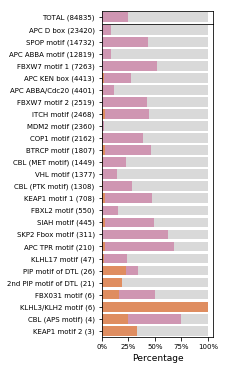

In [78]:
fig,ax = plt.subplots(nrows=2,ncols=1)
fig.set_size_inches(2, 6)

gs = gridspec.GridSpec(2, 1,height_ratios=[1,24])
gs.update(wspace=0.00, hspace=0.00)
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
# Define colors
p = {"Motif match":"#d9d9d9","High confidence novel instance":"#923a66e8","novel instance":"#d98cb2b3","High confidence novel instance with interacting E3":"#f4874b"}
# Plot global numbers
d_motif["Total"] = "Total"
d_novel_instance_general["Total"] = "Total"
d_hconf_novel_instance_ppi_general["Total"] = "Total"

g = sns.barplot(data=d_motif,y="Total",x="Percentage",color=p["Motif match"],errwidth=0.5,ax=ax0,errcolor="black")
g = sns.barplot(data=d_novel_instance_general,y="Total",x="Percentage",color=p["novel instance"],ax=ax0,errwidth=0.5,errcolor="black")
g = sns.barplot(data=d_hconf_novel_instance_ppi_general,y="Total",x="Percentage",color=p["High confidence novel instance with interacting E3"],ax=ax0,errwidth=0.5,errcolor="black")

ax0.set_yticklabels(["TOTAL ("+str(df_properties_degron_info.shape[0]) +")"],fontsize=7)
ax0.set_xticklabels([])
ax0.set_ylabel("")


# Define order by number of instances
order=d_sum.sort_values("SUM",ascending=False)["DEGRON"].values
# Plot it
g = sns.barplot(data=d_motif,y="DEGRON",x="Percentage",color=p["Motif match"],ax=ax1,order=order)
g = sns.barplot(data=d_novel_instance,y="DEGRON",x="Percentage",color=p["novel instance"],ax=ax1,order=order)
g = sns.barplot(data=d_hconf_novel_instance_ppi,y="DEGRON",x="Percentage",color=p["High confidence novel instance with interacting E3"],ax=ax1,order=order)

# Configure axis
labels = []
for index,row in d_sum.sort_values("SUM",ascending=False).iterrows():
    labels.append(names_degrons[row["DEGRON"]]+" ("+str(row["SUM"])+")")
    
_=ax1.set_yticklabels(labels,fontsize=7)

_=ax1.set_xlabel("Percentage",fontsize=9)
_=ax1.set_ylabel("",fontsize=12)

_=ax0.set_xticks([])
_=ax0.set_xticklabels([])

_=ax1.set_xticks(np.arange(0,125,25))
_=ax1.set_xticklabels([str(x)+"%" for x in np.arange(0,125,25)],fontsize=7)


# Save it
plt.savefig(path_output_plots+'/Figure1e_predicted_instances.pdf', dpi=800,bbox_inches="tight")

### Supplementary S1g,h,i (Plot of the correlation between sequence lenght and number of degrons)

In [6]:
from scipy import stats

#### Set sequence lenght

In [12]:
def calculate_lenght(row):
    return len(list(row["Sequence"]))
    
df_sequences["Lenght"] = df_sequences.apply(lambda row: calculate_lenght(row),axis=1)

##### S1g- All regex matches

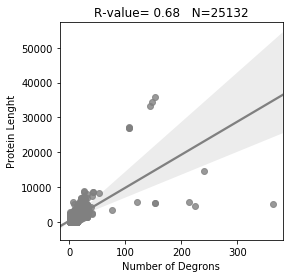

In [17]:
counts_protein = df_properties_degron_info.groupby("Entry_Isoform",as_index=False).agg({"DEGRON":"count"})
counts_protein_lenght = counts_protein.merge(df_sequences[["Entry_Isoform","Lenght"]])
fig,ax=plt.subplots(figsize=(4,4))
sns.regplot(data=counts_protein_lenght,x="DEGRON",y="Lenght",color="grey",ax=ax)
a,b,r_value,pvalue,_=stats.linregress(x=counts_protein_lenght["DEGRON"].values,y=counts_protein_lenght["Lenght"].values)
ax.set_title("R-value= %0.2f" % (r_value) + f"   N="+str(len(counts_protein_lenght["DEGRON"].values)))
ax.set_xlabel("Number of Degrons",fontsize=10)
ax.set_ylabel("Protein Lenght",fontsize=10)
plt.savefig(path_output_plots+'/FigureS1g_corr.png', dpi=800,bbox_inches="tight")

##### S1h - Regex + Features

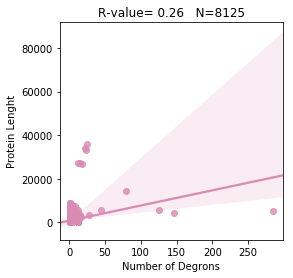

In [20]:
counts_protein = df_properties_degron_info[df_properties_degron_info["Class_PPI_Text"]=="novel instance"].groupby("Entry_Isoform",as_index=False).agg({"DEGRON":"count"})
counts_protein_lenght = counts_protein.merge(df_sequences[["Entry_Isoform","Lenght"]])
fig,ax=plt.subplots(figsize=(4,4))
sns.regplot(data=counts_protein_lenght,x="DEGRON",y="Lenght",color=p["novel instance"],ax=ax)
a,b,r_value,pvalue,_=stats.linregress(x=counts_protein_lenght["DEGRON"].values,y=counts_protein_lenght["Lenght"].values)
ax.set_title("R-value= %0.2f" % (r_value) + f"   N="+str(len(counts_protein_lenght["DEGRON"].values)))
ax.set_xlabel("Number of Degrons",fontsize=10)
ax.set_ylabel("Protein Lenght",fontsize=10)
plt.savefig(path_output_plots+'/FigureS1h_corr.png', dpi=800,bbox_inches="tight")

##### S1i- Regex + Features + PPI

In [22]:
ddpath_output_plots

'../plots/Figure1'

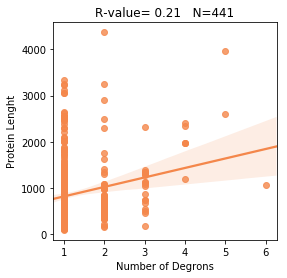

In [21]:
counts_protein = df_properties_degron_info[df_properties_degron_info["Class_PPI_Text"]=="High confidence novel instance with interacting E3"].groupby("Entry_Isoform",as_index=False).agg({"DEGRON":"count"})
counts_protein_lenght = counts_protein.merge(df_sequences[["Entry_Isoform","Lenght"]])
fig,ax=plt.subplots(figsize=(4,4))
sns.regplot(data=counts_protein_lenght,x="DEGRON",y="Lenght",color=p["High confidence novel instance with interacting E3"],ax=ax)
a,b,r_value,pvalue,_=stats.linregress(x=counts_protein_lenght["DEGRON"].values,y=counts_protein_lenght["Lenght"].values)
ax.set_title("R-value= %0.2f" % (r_value) + f"   N="+str(len(counts_protein_lenght["DEGRON"].values)))
ax.set_xlabel("Number of Degrons",fontsize=10)
ax.set_ylabel("Protein Lenght",fontsize=10)
plt.savefig(path_output_plots+'/FigureS1i_corr.png', dpi=800,bbox_inches="tight")

### Visualization of degorn-specific distribution of scores (Figure S2)

In [5]:
df_properties_degron_info = pd.read_csv(path_output_dataframe,sep="\t")

In [6]:
df_properties_degron_info[df_properties_degron_info["DEGRON"].str.contains("FBXL2")]

Entry Entry_Isoform     DEGRON  START   END   ASA_SCORE  CONS_SCORE  \
157    A1KZ92      A1KZ92-1  SCF_FBXL2   1142  1146   66.200000    0.837390   
205    A2A288      A2A288-1  SCF_FBXL2    409   418   89.970000    0.349541   
256    A2VEC9      A2VEC9-1  SCF_FBXL2   2851  2856   62.616667    0.733158   
362    A4FU01      A4FU01-1  SCF_FBXL2    373   379   89.742857    0.709361   
366    A4FU01      A4FU01-4  SCF_FBXL2    301   307   89.742857    0.502793   
667    A6NJZ7      A6NJZ7-1  SCF_FBXL2    661   670   88.270000    0.357539   
674    A6NK53      A6NK53-1  SCF_FBXL2    413   422   79.370000    0.413322   
759    A6NNM3      A6NNM3-1  SCF_FBXL2    661   670   88.270000    0.356929   
781    A7E2Y1      A7E2Y1-1  SCF_FBXL2    837   847   91.809091    0.594840   
947    B0I1T2      B0I1T2-1  SCF_FBXL2    717   727   65.272727    0.615415   
962    B2RTY4      B2RTY4-1  SCF_FBXL2   1145  1155   59.581818    0.585447   
1009   C9JR72      C9JR72-1  SCF_FBXL2     62    69   60.375000    0.758714   
1099   O00159      O00159-1  SCF_FBXL2    741   751   65.209091    0.629541   
1100   O00159      O00159-1  SCF_FBXL2    764   774   60.318182    0.379634   
1104   O00159      O00159-2  SCF_FBXL2    706   716   65.209091    0.764563   
1105   O00159      O00159-2  SCF_FBXL2    729   739   60.318182    0.604313   
1109   O00159      O00159-3  SCF_FBXL2    722   732   65.209091    0.707272   
1110   O00159      O00159-3  SCF_FBXL2    745   755   60.318182    0.608253   
1154   O00219      O00219-1  SCF_FBXL2    398   405   76.862500    0.389591   
1267   O00408      O00408-1  SCF_FBXL2    194   200   87.628571    0.247143   
1274   O00408      O00408-2  SCF_FBXL2    173   179   87.628571    0.253591   
1281   O00408      O00408-3  SCF_FBXL2    187   193   87.628571    0.248554   
1288   O00408      O00408-4  SCF_FBXL2    185   191   87.628571    0.251897   
1306   O00425      O00425-1  SCF_FBXL2    165   172   95.925000    0.367943   
1415   O00481      O00481-1  SCF_FBXL2    317   325   82.800000    0.236954   
1419   O00481      O00481-2  SCF_FBXL2    317   325   81.744444    0.236954   
1423   O00481      O00481-3  SCF_FBXL2    317   325   82.144444    0.236954   
1429   O00481      O00481-4  SCF_FBXL2    265   273   82.866667    0.310536   
1885   O14686      O14686-1  SCF_FBXL2   5169  5174   83.750000    0.467077   
2066   O14829      O14829-1  SCF_FBXL2     23    33   59.354545    0.457635   
...       ...           ...        ...    ...   ...         ...         ...   
80766  Q9NRI5      Q9NRI5-6  SCF_FBXL2    120   127   57.162500    0.436460   
80771  Q9NRI5      Q9NRI5-7  SCF_FBXL2    120   127   57.162500    0.436460   
80777  Q9NRI5      Q9NRI5-8  SCF_FBXL2    120   127   57.250000    0.436460   
80783  Q9NRI5      Q9NRI5-9  SCF_FBXL2    120   127   57.237500    0.436460   
80933  Q9NTN9      Q9NTN9-1  SCF_FBXL2    547   555   81.655556    0.336069   
80940  Q9NTN9      Q9NTN9-2  SCF_FBXL2    552   560   83.877778    0.367983   
80946  Q9NTN9      Q9NTN9-3  SCF_FBXL2    552   560   83.444444    0.367983   
81852  Q9P253      Q9P253-1  SCF_FBXL2    837   843   79.657143    0.458593   
82163  Q9UBL9      Q9UBL9-7  SCF_FBXL2    131   138   62.300000    0.424463   
82171  Q9UBN4      Q9UBN4-1  SCF_FBXL2    884   894   66.181818    0.282471   
82174  Q9UBN4      Q9UBN4-2  SCF_FBXL2    800   810   66.345455    0.275228   
82177  Q9UBN4      Q9UBN4-3  SCF_FBXL2    743   753   65.490909    0.537441   
82180  Q9UBN4      Q9UBN4-4  SCF_FBXL2    735   745   66.190909    0.598075   
82183  Q9UBN4      Q9UBN4-5  SCF_FBXL2    889   899   66.181818    0.295159   
82186  Q9UBN4      Q9UBN4-6  SCF_FBXL2    711   721   66.181818    0.555187   
82624  Q9UJT2      Q9UJT2-1  SCF_FBXL2    383   389   87.842857    0.993461   
83275  Q9ULJ7      Q9ULJ7-1  SCF_FBXL2     99   105   64.928571    0.374820   
83437  Q9ULW3      Q9ULW3-1  SCF_FBXL2    186   194   74.111111    0.464490   
83530  Q9UNS1      Q9UNS1-1  SCF_FBXL2    269   274  106.4

/home/fran/Downloads/yes/envs/regression/lib/python3.6/site-packages/numpy/lib/histograms.py:823: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/home/fran/Downloads/yes/envs/regression/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/fran/Downloads/yes/envs/regression/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/fran/Downloads/yes/envs/regression/lib/python3.6/site-packages/statsmodels/nonparametric/bandwidths.py:20: RuntimeWarning: invalid value encountered in minimum
  return np.minimum(np.std(X, axis=0, ddof=1), IQR)
/home/fran/Downloads/yes/envs/regression/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/fran/Downloads/y

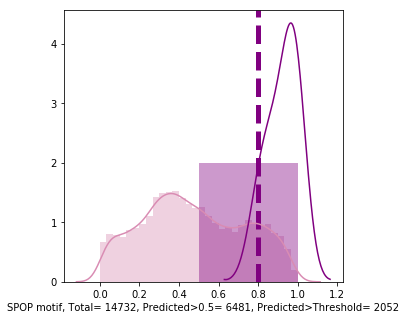

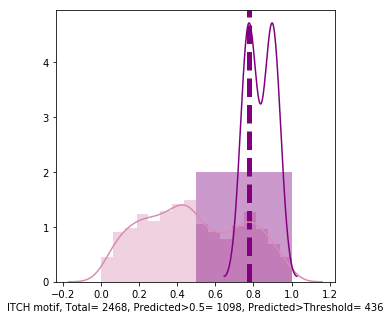

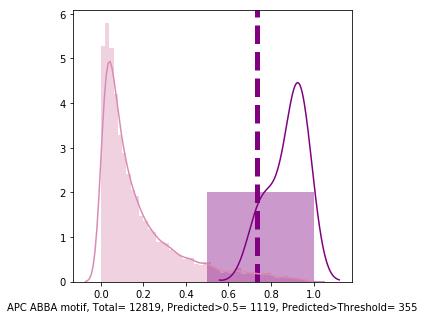

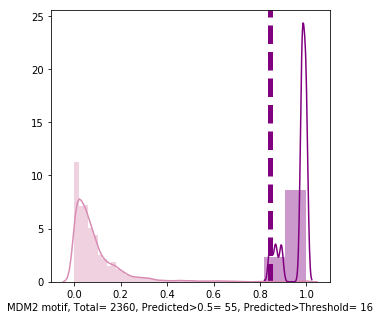

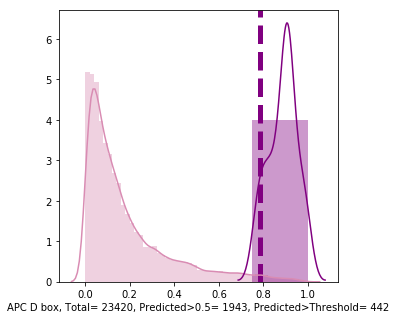

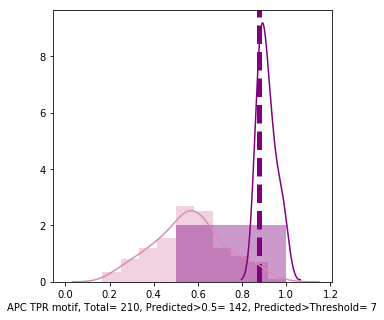

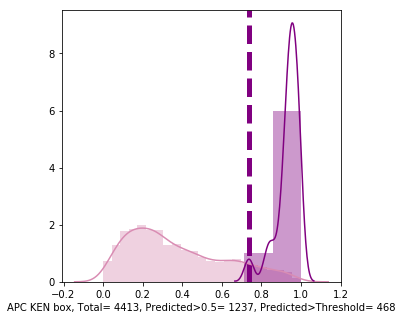

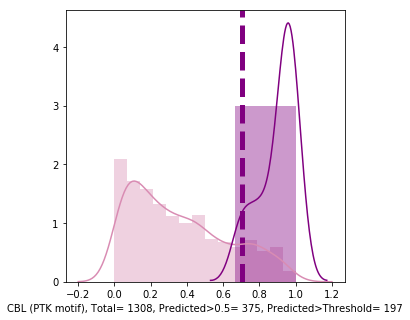

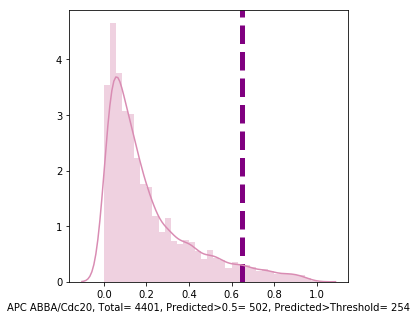

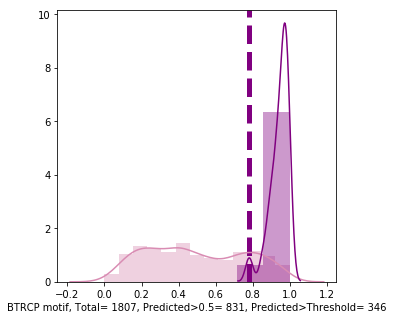

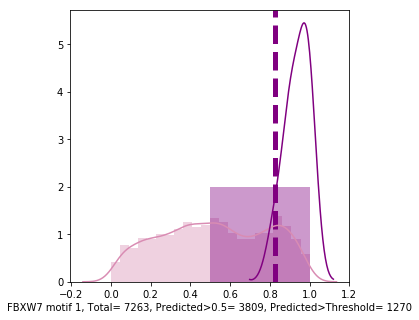

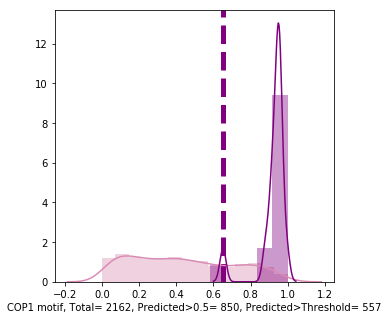

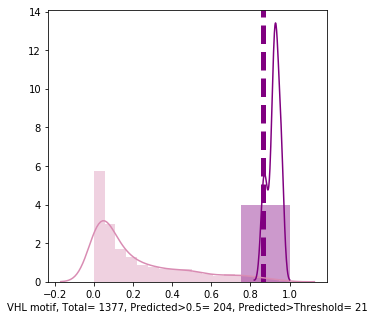

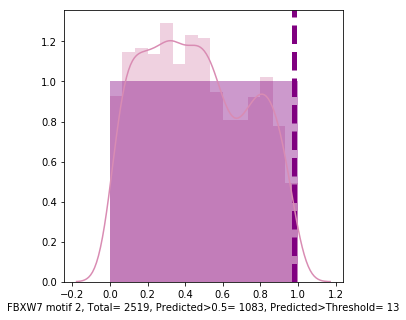

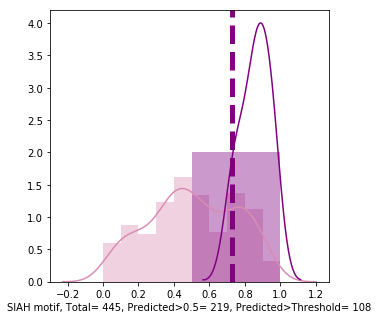

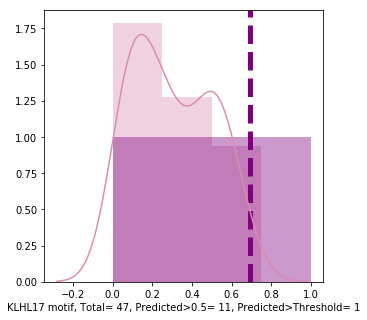

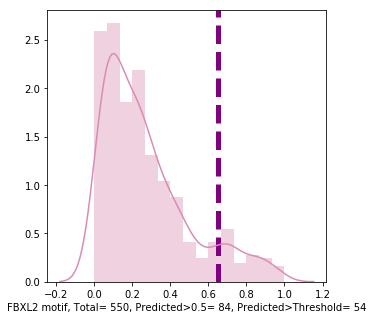

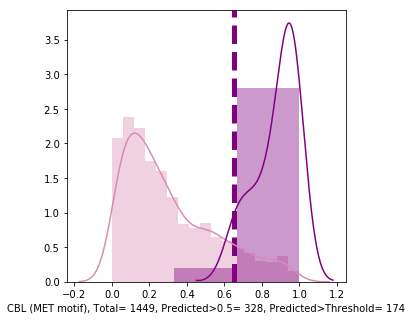

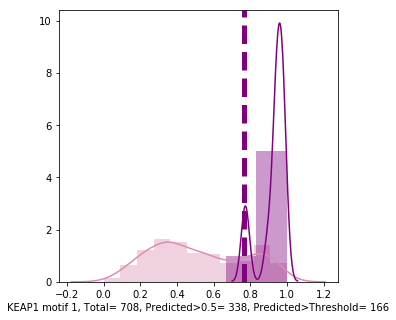

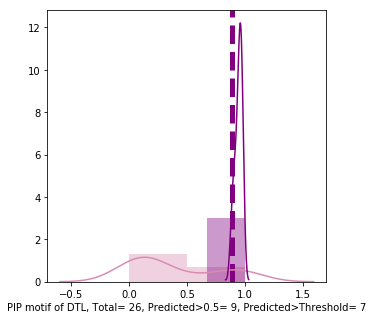

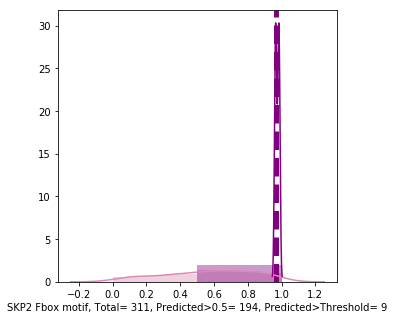

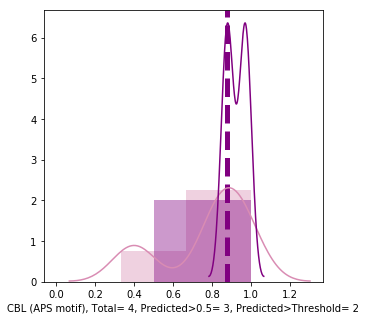

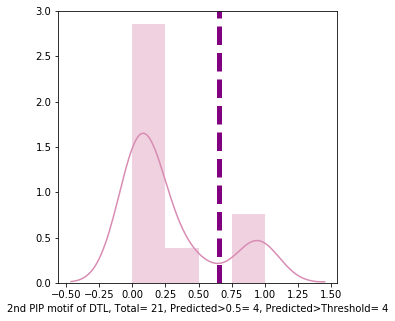

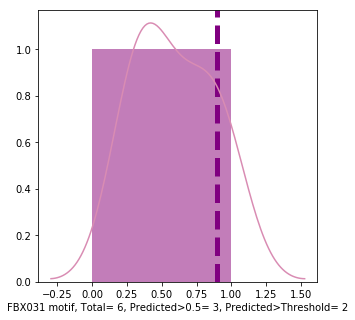

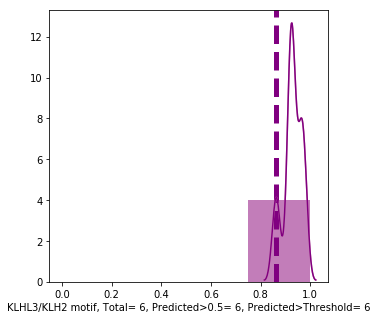

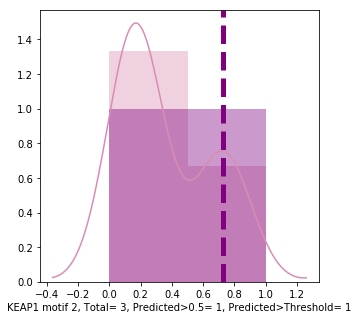

In [93]:
degrons = df_properties_degron_info["DEGRON"].unique()
i = 0
for degron in degrons:
    a = df_properties_degron_info[(df_properties_degron_info["DEGRON"]==degron)&(df_properties_degron_info["Prob_DEGRON"]>0.5)].shape[0]
    b = df_properties_degron_info[(df_properties_degron_info["DEGRON"]==degron)].shape[0]
    c =df_properties_degron_info[(df_properties_degron_info["DEGRON"]==degron)&(df_properties_degron_info["Class"]=="DEGRON")].shape[0]
    a = "%s, Total= %d, Predicted>0.5= %d, Predicted>Threshold= %d"%(names_degrons[degron],b,a,c)
    
    fig,ax = plt.subplots(figsize=(5,5))
    ax.axvline(x=d_values[degron][1],lw=5,color="purple",ls="--") # Minimum of the class
    
    sns.distplot(df_properties_degron_info[df_properties_degron_info["DEGRON"]==degron]["Prob_DEGRON"].values,axlabel=a,color="#d98cb3",ax=ax,kde_kws={'clip': (0.0, 1.0)},hist_kws={"range": [0,1.0]},rug_kws={"clip": [0,1.0]})
    sns.distplot(df_properties_degron_info[(df_properties_degron_info["DEGRON"]==degron)&(df_properties_degron_info["Annotated"]=="YES")]["Prob_DEGRON"].values,color="purple",ax=ax,kde_kws={'clip': (0.0, 1.0)},hist_kws={"range": [0,1.0]},rug_kws={"clip": [0,1.0]})
    plt.savefig(path_output_plots+'/distribution_scores/'+degron+'_dist_plot.pdf', dpi=800,bbox_inches="tight")
    plt
    i = i +1 

df_

### SPOP

In [15]:
df_properties_degron_info[(df_properties_degron_info["DEGRON"].str.contains("DEG_Kelch_KLHL3_1"))&(df_properties_degron_info["Class"]!="DEGRON")].shape

(0, 48)

In [11]:
df_properties_degron_info.columns.values

array(['Entry', 'Entry_Isoform', 'DEGRON', 'START', 'END', 'ASA_SCORE',
       'CONS_SCORE', 'FCONS_SCORE', 'COIL', 'HELIX', 'STRAND',
       'DSS_SCORE', 'RIG_SCORE', 'ANCHOR_SCORE', 'Domain_pfam',
       'nflanking_ub_lysines', 'ub_lysines', 'nflanking_lysines',
       'any_lysines', 'nflanking_ptms', 'ptms_flanking', 'Z_ASA', 'Z_DSS',
       'Z_CONS', 'Z_FCONS', 'Z_SS_C', 'Z_SS_H', 'Z_SS_E', 'Z_RIG',
       'Z_ANCHOR', 'Z_DOMAIN', 'Z_FLANKING_UB_LYSINE',
       'Z_FLANKING_LYSINE', 'Z_PTMS', 'Hugo_Symbol', 'CCDS', 'Hit',
       'Annotated', 'Database', 'E3', 'PPI', 'Prob_DEGRON', 'Prob_RANDOM',
       'Predicted_Class', 'Min_Class', 'Class', 'Class_PPI_Threshold',
       'Class_PPI_Text'], dtype=object)